   Year      Month  \
0  2024   November   
1  2024    October   
2  2024  September   
3  2024     August   
4  2024       July   

   Food at home sales million nominal U.S. dollars with taxes and tips  \
0                                           95656.09                     
1                                           93264.84                     
2                                           88347.26                     
3                                           93574.33                     
4                                           92725.62                     

   Food away from home sales million nominal U.S. dollars with taxes and tips  \
0                                          114435.81                            
1                                          117611.72                            
2                                          113183.13                            
3                                          120947.75                            
4                

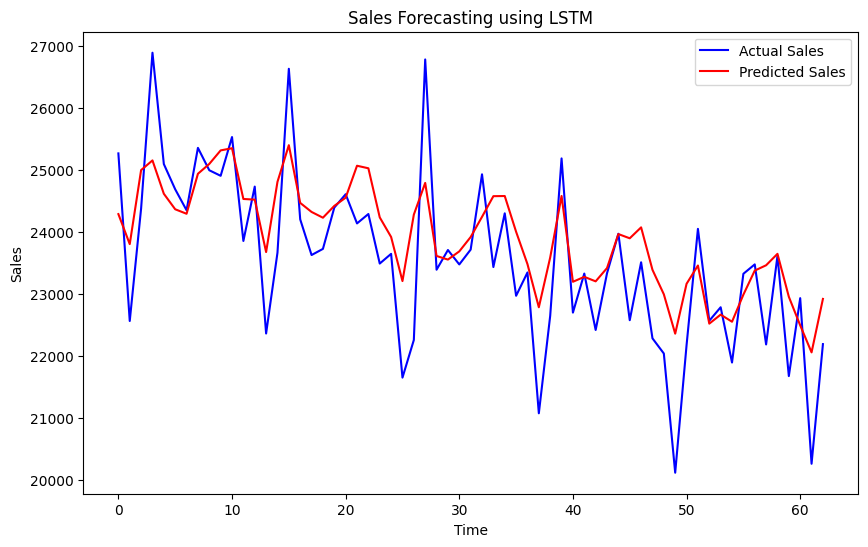

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

# Step 1: Import the merged data
merged_data = pd.read_csv('merged_food_market_data.csv')

# Check the first few rows to understand the structure of the data
print(merged_data.head())

# Step 2: Handle missing values (if any)
# You can drop rows with missing values or fill them with a specific value
merged_data.dropna(inplace=True)  # Remove missing values, or you can use fillna() for filling

# Step 3: If necessary, create a 'Date' column if not already present
# Assuming 'Year' and 'Month' columns exist, we create a 'Date' column
if 'Date' not in merged_data.columns:
    merged_data['Date'] = pd.to_datetime(merged_data['Month'] + ' ' + merged_data['Year'].astype(str))

# Step 4: Select the column to predict (you can replace with your target column name)
column_to_predict = 'Grocery stores sales million nominal U.S. dollars with taxes and tips'  # Replace with your column name

# Ensure that the column exists
if column_to_predict not in merged_data.columns:
    raise KeyError(f"The column '{column_to_predict}' is not in the dataset!")

# Select only the target column for prediction
data = merged_data[[column_to_predict]]

# Step 5: Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 6: Create the dataset for LSTM
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare data for training and testing
time_step = 12  # Number of time steps (months in this case)
X, y = create_dataset(scaled_data, time_step)

# Reshape X to be 3D as required by LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 8: Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 9: Train the LSTM model
history = model.fit(X_train, y_train, epochs=100, batch_size=2, validation_data=(X_test, y_test), verbose=1)

# Step 10: Make predictions using the model
predictions = model.predict(X_test)

# Step 11: Inverse transform the predictions and actual values to get them back to the original scale
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 12: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Sales')
plt.plot(predictions, color='red', label='Predicted Sales')
plt.title('Sales Forecasting using LSTM')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


Note: you may need to restart the kernel to use updated packages.


In [1]:
df_merged.info()

NameError: name 'df_merged' is not defined

In [9]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, 11 to 334
Data columns (total 27 columns):
 #   Column                                                                                         Non-Null Count  Dtype  
---  ------                                                                                         --------------  -----  
 0   Year                                                                                           324 non-null    int64  
 1   Month                                                                                          324 non-null    object 
 2   Food at home sales million nominal U.S. dollars with taxes and tips                            324 non-null    float64
 3   Food away from home sales million nominal U.S. dollars with taxes and tips                     324 non-null    float64
 4   Total food sales million nominal U.S. dollars with taxes and tips                              324 non-null    float64
 5   Food at home sales million

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 13: Calculate metrics

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_actual, predictions)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_actual, predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R-squared (R²)
r2 = r2_score(y_test_actual, predictions)

# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


Mean Absolute Error (MAE): 702.7212549603171
Mean Squared Error (MSE): 818201.2641387522
Root Mean Squared Error (RMSE): 904.544782826562
R-squared (R²): 0.5669351426425613


In [17]:
pip install keras-tuner


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential  # Add this import
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Import the merged data
merged_data = pd.read_csv('merged_food_market_data.csv')

# Check the first few rows to understand the structure of the data
print(merged_data.head())

# Step 2: Handle missing values (if any)
# You can drop rows with missing values or fill them with a specific value
merged_data.dropna(inplace=True)  # Remove missing values, or you can use fillna() for filling

# Step 3: If necessary, create a 'Date' column if not already present
# Assuming 'Year' and 'Month' columns exist, we create a 'Date' column
if 'Date' not in merged_data.columns:
    merged_data['Date'] = pd.to_datetime(merged_data['Month'] + ' ' + merged_data['Year'].astype(str))

# Step 4: Select the column to predict (you can replace with your target column name)
column_to_predict = 'Grocery stores sales million nominal U.S. dollars with taxes and tips'  # Replace with your column name

# Ensure that the column exists
if column_to_predict not in merged_data.columns:
    raise KeyError(f"The column '{column_to_predict}' is not in the dataset!")

# Select only the target column for prediction
data = merged_data[[column_to_predict]]

# Step 5: Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 6: Create the dataset for LSTM
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare data for training and testing
time_step = 12  # Number of time steps (months in this case)
X, y = create_dataset(scaled_data, time_step)

# Reshape X to be 3D as required by LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 8: Define a model-building function that includes the hyperparameters
def build_model(hp):
    model = Sequential()
    
    # Add the first LSTM layer with variable units
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=150, step=50), 
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    
    # Add a Dropout layer for regularization
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Add the second LSTM layer with variable units
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=150, step=50), 
                   return_sequences=False))
    
    # Add a Dropout layer for regularization
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Add the output layer
    model.add(Dense(units=1))
    
    # Compile the model with a variable learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')), 
                  loss='mean_squared_error')
    
    return model

# Step 9: Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_loss',  # We want to minimize validation loss
                     max_epochs=100,         # The maximum number of epochs to train the model
                     factor=3,               # Factor used to reduce the search space
                     directory='my_dir',     # Directory to store tuner results
                     project_name='hyperparameter_tuning')

# Step 10: Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=100, batch_size=2, validation_data=(X_test, y_test), verbose=1)

# Step 11: Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hyperparameters.values}")

# Step 12: Evaluate the best model on the test data
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Step 13: Make predictions with the best model
predictions = best_model.predict(X_test)

# Step 14: Inverse transform the predictions and actual values to get them back to the original scale
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 15: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Sales')
plt.plot(predictions, color='red', label='Predicted Sales')
plt.title('Sales Forecasting using Optimized LSTM')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Step 16: Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"Optimized Mean Absolute Error (MAE): {mae}")
print(f"Optimized Mean Squared Error (MSE): {mse}")
print(f"Optimized Root Mean Squared Error (RMSE): {rmse}")
print(f"Optimized R-squared (R²): {r2}")


Trial 227 Complete [00h 00m 15s]
val_loss: 0.001492041046731174

Best val_loss So Far: 0.001236744923517108
Total elapsed time: 00h 35m 41s

Search: Running Trial #228

Value             |Best Value So Far |Hyperparameter
100               |50                |units_1
0.4               |0.4               |dropout_1
100               |150               |units_2
0.2               |0.2               |dropout_2
1.6722e-05        |0.00021686        |learning_rate
12                |100               |tuner/epochs
0                 |34                |tuner/initial_epoch
2                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Epoch 1/12
125/125 [==============================] - 4s 12ms/step - loss: 0.1751 - val_loss: 0.0046
Epoch 2/12
125/125 [==============================] - 1s 8ms/step - loss: 0.0739 - val_loss: 0.0018
Epoch 3/12
125/125 [==============================] - 1s 7ms/step - loss: 0.0165 - val_loss: 0.0072
Epoch 4/12
125/125 [=====

KeyboardInterrupt: 

In [2]:
pip install Sequential

  Preparing metadata (setup.py) ... done
  Created wheel for Sequential: filename=sequential-1.0.0-py3-none-any.whl size=2860 sha256=8932c9425dc58cedab8652e60f7d652d74c7bd5c19fc8281106fd31114efd541
  Stored in directory: /home/iyed/.cache/pip/wheels/d0/3c/18/25bc0c5ef268ffb0e7ec631e2dde620b8c688586e9bb0bfa52
Successfully built Sequential
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Get the best trial's hyperparameters
best_trial = tuner.oracle.get_best_trials(1)[0]  # Get the best trial

# Extract the hyperparameters from the best trial
best_hyperparameters = best_trial.hyperparameters.values
print(best_hyperparameters)


{'units_1': 50, 'dropout_1': 0.4, 'units_2': 150, 'dropout_2': 0.2, 'learning_rate': 0.00021686067491772116, 'tuner/epochs': 100, 'tuner/initial_epoch': 34, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0203'}


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Best hyperparameters
best_hyperparameters = {
    'units_1': 50,
    'dropout_1': 0.4,
    'units_2': 150,
    'dropout_2': 0.2,
    'learning_rate': 0.00021686067491772116,
}

# Rebuild the model with best hyperparameters
model = Sequential()
model.add(LSTM(units=best_hyperparameters['units_1'], return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(best_hyperparameters['dropout_1']))
model.add(LSTM(units=best_hyperparameters['units_2']))
model.add(Dropout(best_hyperparameters['dropout_2']))
model.add(Dense(1))

# Compile the model with the specified learning rate
optimizer = Adam(learning_rate=best_hyperparameters['learning_rate'])
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with your data (X_train, y_train)
history = model.fit(X_train, y_train, epochs=100, batch_size=2, validation_data=(X_test, y_test), verbose=1)

# Step 2: Evaluate the model on test data
predictions = model.predict(X_test)

# Inverse transform predictions and actual values
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_actual_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
mae = mean_absolute_error(y_test_actual_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_actual_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual_rescaled, predictions_rescaled)

# Display the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Epoch 1/100
125/125 [==============================] - 4s 12ms/step - loss: 0.0245 - val_loss: 0.0054
Epoch 2/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 3/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 4/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 5/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 6/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 7/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 8/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 9/100
125/125 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 10/100
125/125 [==============================] - 1s 9ms/step - loss: 0.0035 - val_l

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential  # Add this import
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Import the merged data
merged_data = pd.read_csv('merged_food_market_data.csv')

# Check the first few rows to understand the structure of the data
print(merged_data.head())

# Step 2: Handle missing values (if any)
# You can drop rows with missing values or fill them with a specific value
merged_data.dropna(inplace=True)  # Remove missing values, or you can use fillna() for filling

# Step 3: If necessary, create a 'Date' column if not already present
# Assuming 'Year' and 'Month' columns exist, we create a 'Date' column
if 'Date' not in merged_data.columns:
    merged_data['Date'] = pd.to_datetime(merged_data['Month'] + ' ' + merged_data['Year'].astype(str))

# Step 4: Select the column to predict (you can replace with your target column name)
column_to_predict = 'Grocery stores sales million nominal U.S. dollars with taxes and tips'  # Replace with your column name

# Ensure that the column exists
if column_to_predict not in merged_data.columns:
    raise KeyError(f"The column '{column_to_predict}' is not in the dataset!")

# Select only the target column for prediction
data = merged_data[[column_to_predict]]

# Step 5: Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 6: Create the dataset for LSTM
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare data for training and testing
time_step = 12  # Number of time steps (months in this case)
X, y = create_dataset(scaled_data, time_step)

# Reshape X to be 3D as required by LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 8: Define a model-building function that includes the hyperparameters
def build_model(hp):
    model = Sequential()
    
    # Add the first LSTM layer with variable units
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=150, step=50), 
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    
    # Add a Dropout layer for regularization
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.4, max_value=0.4, step=0.0)))
    
    # Add the second LSTM layer with variable units
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=150, step=50), 
                   return_sequences=False))
    
    # Add a Dropout layer for regularization
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    # Add the output layer
    model.add(Dense(units=1))
    
    # Compile the model with a variable learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')), 
                  loss='mean_squared_error')
    
    return model

# Step 9: Initialize the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_loss',  # We want to minimize validation loss
                     max_epochs=10**4,         # The maximum number of epochs to train the model
                     factor=3,               # Factor used to reduce the search space
                     directory='my_dir',     # Directory to store tuner results
                     project_name='hyperparameter_tuning')

# Step 10: Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10**4, batch_size=2, validation_data=(X_test, y_test), verbose=1)

# Step 11: Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hyperparameters.values}")

# Step 12: Evaluate the best model on the test data
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Step 13: Make predictions with the best model
predictions = best_model.predict(X_test)

# Step 14: Inverse transform the predictions and actual values to get them back to the original scale
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 15: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Sales')
plt.plot(predictions, color='red', label='Predicted Sales')
plt.title('Sales Forecasting using Optimized LSTM')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Step 16: Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"Optimized Mean Absolute Error (MAE): {mae}")
print(f"Optimized Mean Squared Error (MSE): {mse}")
print(f"Optimized Root Mean Squared Error (RMSE): {rmse}")
print(f"Optimized R-squared (R²): {r2}")


Trial 230 Complete [00h 00m 29s]
val_loss: 0.0012774759670719504

Best val_loss So Far: 0.001236744923517108
Total elapsed time: 00h 43m 43s

Search: Running Trial #231

Value             |Best Value So Far |Hyperparameter
100               |50                |units_1
0.3               |0.4               |dropout_1
100               |150               |units_2
0.2               |0.2               |dropout_2
0.00018685        |0.00021686        |learning_rate
34                |100               |tuner/epochs
12                |34                |tuner/initial_epoch
2                 |3                 |tuner/bracket
1                 |3                 |tuner/round
0212              |0203              |tuner/trial_id

Epoch 13/34
125/125 [==============================] - 4s 12ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 14/34
125/125 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 15/34
125/125 [==============================] - 1s 6ms/step - 

KeyboardInterrupt: 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Import the merged data
merged_data = pd.read_csv('merged_food_market_data.csv')

# Check the first few rows to understand the structure of the data
print(merged_data.head())

# Step 2: Handle missing values (if any)
merged_data.dropna(inplace=True)  # Remove missing values, or you can use fillna() for filling

# Step 3: If necessary, create a 'Date' column if not already present
if 'Date' not in merged_data.columns:
    merged_data['Date'] = pd.to_datetime(merged_data['Month'] + ' ' + merged_data['Year'].astype(str))

# Step 4: Select the column to predict
column_to_predict = 'Grocery stores sales million nominal U.S. dollars with taxes and tips'

if column_to_predict not in merged_data.columns:
    raise KeyError(f"The column '{column_to_predict}' is not in the dataset!")

data = merged_data[[column_to_predict]]

# Step 5: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 6: Create the dataset for LSTM
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare data for training and testing
time_step = 12  # Number of time steps (months in this case)
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 8: Define a model-building function
def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=150, step=50), 
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.6, step=0.1)))
    
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=150, step=50), 
                   return_sequences=False))
    
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=1))
    
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')), 
                  loss='mean_squared_error')
    
    return model

# Step 9: Initialize the tuner with early stopping and dynamic training duration
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=100,  # Limit number of epochs for faster tuning
                     factor=3,
                     directory='my_dir',
                     project_name='hyperparameter_tuning',
                     overwrite=True)

# Step 10: Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=500, batch_size=2, validation_data=(X_test, y_test), verbose=1)

# Step 11: Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hyperparameters.values}")

# Step 12: Evaluate the best model on the test data
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Step 13: Make predictions with the best model
predictions = best_model.predict(X_test)

# Step 14: Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 15: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Sales')
plt.plot(predictions, color='red', label='Predicted Sales')
plt.title('Sales Forecasting using Optimized LSTM')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Step 16: Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"Optimized Mean Absolute Error (MAE): {mae}")
print(f"Optimized Mean Squared Error (MSE): {mse}")
print(f"Optimized Root Mean Squared Error (RMSE): {rmse}")
print(f"Optimized R-squared (R²): {r2}")


Trial 68 Complete [00h 00m 06s]
val_loss: 0.0032345287036150694

Best val_loss So Far: 0.0012909702491015196
Total elapsed time: 00h 06m 47s

Search: Running Trial #69

Value             |Best Value So Far |Hyperparameter
50                |50                |units_1
0.4               |0.3               |dropout_1
50                |75                |units_2
0.3               |0.3               |dropout_2
0.0032148         |0.00075383        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


KeyboardInterrupt: 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Import the merged data
merged_data = pd.read_csv('merged_food_market_data.csv')

# Check the first few rows to understand the structure of the data
print(merged_data.head())

# Step 2: Handle missing values (if any)
merged_data.dropna(inplace=True)  # Remove missing values, or you can use fillna() for filling

# Step 3: If necessary, create a 'Date' column if not already present
if 'Date' not in merged_data.columns:
    merged_data['Date'] = pd.to_datetime(merged_data['Month'] + ' ' + merged_data['Year'].astype(str))

# Step 4: Select the column to predict
column_to_predict = 'Grocery stores sales million nominal U.S. dollars with taxes and tips'

if column_to_predict not in merged_data.columns:
    raise KeyError(f"The column '{column_to_predict}' is not in the dataset!")

data = merged_data[[column_to_predict]]

# Step 5: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 6: Create the dataset for LSTM
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare data for training and testing
time_step = 4  # Number of time steps (months in this case)
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 8: Define a model-building function using SGD optimizer
def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=1500, step=75), 
                   return_sequences=True, input_shape=(X_train.shape[1], 1)))
    
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.6, step=0.1)))
    
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=1500, step=75), 
                   return_sequences=False))
    
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=1))

    # Use SGD with learning rate and momentum as hyperparameters
    model.compile(optimizer=SGD(learning_rate=hp.Float('learning_rate', min_value=1e-3, max_value=1e-2, sampling='LOG'),
                                momentum=hp.Float('momentum', min_value=0.1, max_value=0.9, step=0.1)), 
                  loss='mean_squared_error')
    
    return model

# Step 9: Initialize the tuner with early stopping and dynamic training duration
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=1000,  # Limit number of epochs for faster tuning
                     factor=3,
                     directory='my_dir',
                     project_name='hyperparameter_tuning',
                     overwrite=True)

# Step 10: Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=1000, batch_size=4, validation_data=(X_test, y_test), verbose=1)

# Step 11: Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hyperparameters.values}")

# Step 12: Evaluate the best model on the test data
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Step 13: Make predictions with the best model
predictions = best_model.predict(X_test)

# Step 14: Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 15: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Sales')
plt.plot(predictions, color='red', label='Predicted Sales')
plt.title('Sales Forecasting using Optimized LSTM')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Step 16: Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"Optimized Mean Absolute Error (MAE): {mae}")
print(f"Optimized Mean Squared Error (MSE): {mse}")
print(f"Optimized Root Mean Squared Error (RMSE): {rmse}")
print(f"Optimized R-squared (R²): {r2}")


Trial 114 Complete [00h 00m 04s]
val_loss: 0.11946447938680649

Best val_loss So Far: 0.001938999630510807
Total elapsed time: 00h 26m 04s

Search: Running Trial #115

Value             |Best Value So Far |Hyperparameter
1025              |875               |units_1
0.4               |0.5               |dropout_1
1475              |1025              |units_2
0.2               |0.3               |dropout_2
0.006504          |0.0011378         |learning_rate
0.6               |0.1               |momentum
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
6                 |6                 |tuner/bracket
0                 |0                 |tuner/round



KeyboardInterrupt: 

   Year      Month  \
0  2024   November   
1  2024    October   
2  2024  September   
3  2024     August   
4  2024       July   

   Food at home sales million nominal U.S. dollars with taxes and tips  \
0                                           95656.09                     
1                                           93264.84                     
2                                           88347.26                     
3                                           93574.33                     
4                                           92725.62                     

   Food away from home sales million nominal U.S. dollars with taxes and tips  \
0                                          114435.81                            
1                                          117611.72                            
2                                          113183.13                            
3                                          120947.75                            
4                

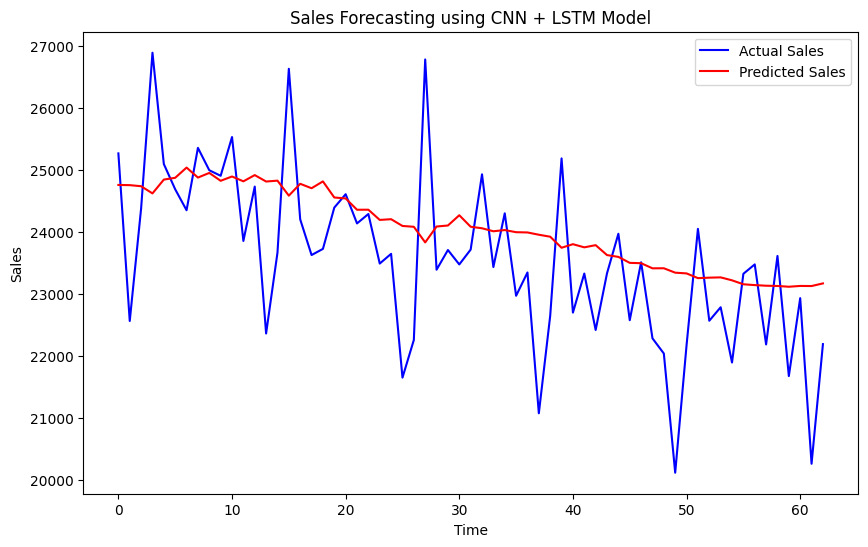

Optimized Mean Absolute Error (MAE): 946.3148214285715
Optimized Mean Squared Error (MSE): 1535170.0713315029
Optimized Root Mean Squared Error (RMSE): 1239.0198026389662
Optimized R-squared (R²): 0.18745150233861851


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Import the merged data
merged_data = pd.read_csv('merged_food_market_data.csv')

# Check the first few rows to understand the structure of the data
print(merged_data.head())

# Step 2: Handle missing values (if any)
merged_data.dropna(inplace=True)  # Remove missing values, or you can use fillna() for filling

# Step 3: If necessary, create a 'Date' column if not already present
if 'Date' not in merged_data.columns:
    merged_data['Date'] = pd.to_datetime(merged_data['Month'] + ' ' + merged_data['Year'].astype(str))

# Step 4: Select the column to predict
column_to_predict = 'Grocery stores sales million nominal U.S. dollars with taxes and tips'

if column_to_predict not in merged_data.columns:
    raise KeyError(f"The column '{column_to_predict}' is not in the dataset!")

data = merged_data[[column_to_predict]]

# Step 5: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 6: Create the dataset for LSTM
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare data for training and testing
time_step = 12  # Number of time steps (months in this case)
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 8: Define a model-building function using CNN + LSTM
def build_cnn_lstm_model():
    model = Sequential()
    
    # Add CNN layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    # Add LSTM layer
    model.add(LSTM(units=100, return_sequences=False))
    
    # Output layer
    model.add(Dense(units=1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model

# Step 9: Build and train the model
model = build_cnn_lstm_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Step 10: Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Step 11: Make predictions with the trained model
predictions = model.predict(X_test)

# Step 12: Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 13: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Sales')
plt.plot(predictions, color='red', label='Predicted Sales')
plt.title('Sales Forecasting using CNN + LSTM Model')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Step 14: Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"Optimized Mean Absolute Error (MAE): {mae}")
print(f"Optimized Mean Squared Error (MSE): {mse}")
print(f"Optimized Root Mean Squared Error (RMSE): {rmse}")
print(f"Optimized R-squared (R²): {r2}")


Trial 603 Complete [00h 01m 01s]
val_loss: 0.0010804797057062387

Best val_loss So Far: 0.0005912526394240558
Total elapsed time: 00h 52m 47s
Best Hyperparameters: {'filters': 64, 'kernel_size': 4, 'dropout_cnn': 0.2, 'lstm_units': 100, 'dropout_lstm': 0.4, 'learning_rate': 0.0013233382550271867, 'tuner/epochs': 1000, 'tuner/initial_epoch': 250, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0533'}
2/2 [==============================] - 0s 5ms/step - loss: 5.9125e-04
Test Loss: 0.0005912526394240558
2/2 [==============================] - 0s 3ms/step


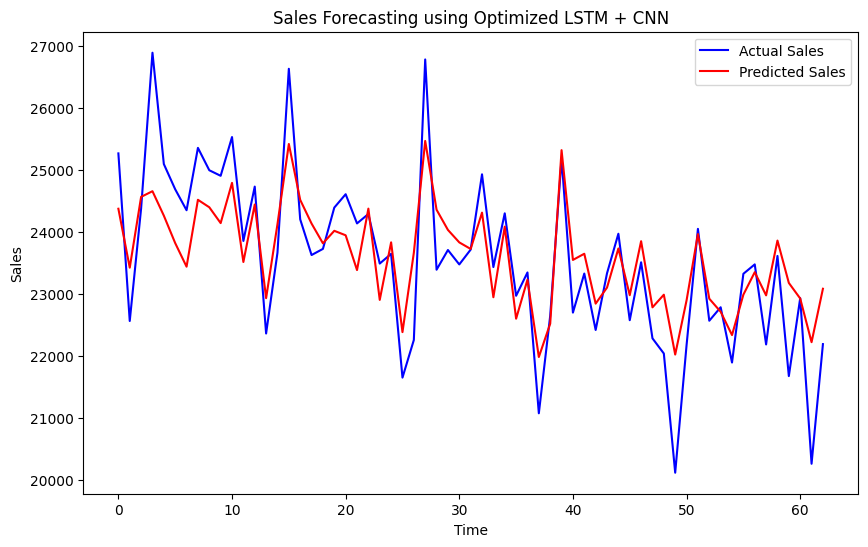

Optimized Mean Absolute Error (MAE): 602.4830257936507
Optimized Mean Squared Error (MSE): 587157.3473675462
Optimized Root Mean Squared Error (RMSE): 766.2619313051812
Optimized R-squared (R²): 0.6892241261057529


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Import the merged data (use your actual data file)
merged_data = pd.read_csv('merged_food_market_data.csv')

# Check the first few rows to understand the structure of the data
print(merged_data.head())

# Step 2: Handle missing values (if any)
merged_data.dropna(inplace=True)  # Remove missing values

# Step 3: If necessary, create a 'Date' column if not already present
if 'Date' not in merged_data.columns:
    merged_data['Date'] = pd.to_datetime(merged_data['Month'] + ' ' + merged_data['Year'].astype(str))

# Step 4: Select the column to predict
column_to_predict = 'Grocery stores sales million nominal U.S. dollars with taxes and tips'

if column_to_predict not in merged_data.columns:
    raise KeyError(f"The column '{column_to_predict}' is not in the dataset!")

data = merged_data[[column_to_predict]]

# Step 5: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 6: Create the dataset for LSTM + CNN
def create_dataset(data, time_step=12):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Prepare data for training and testing
time_step = 12  # Number of time steps (months in this case)
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 8: Define a model-building function using CNN + LSTM and hyperparameters for both
def build_model(hp):
    model = Sequential()

    # CNN layer (1D Convolutional layer)
    model.add(Conv1D(filters=hp.Int('filters', min_value=16, max_value=64, step=16),
                     kernel_size=hp.Int('kernel_size', min_value=3, max_value=7, step=1),
                     activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(rate=hp.Float('dropout_cnn', min_value=0.2, max_value=0.5, step=0.1)))

    # LSTM layer
    model.add(LSTM(units=hp.Int('lstm_units', min_value=50, max_value=150, step=25), 
                   return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_lstm', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Dense output layer
    model.add(Dense(units=1))

    # Use Adam optimizer with learning rate hyperparameter
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')

    return model

# Step 9: Initialize the tuner with early stopping and dynamic training duration
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=1000,  # Limit number of epochs for faster tuning
                     factor=4,
                     directory='my_dir',
                     project_name='lstm_cnn_hyperparameter_tuning',
                     overwrite=True)

# Step 10: Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Step 11: Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hyperparameters.values}")

# Step 12: Evaluate the best model on the test data
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

# Step 13: Make predictions with the best model
predictions = best_model.predict(X_test)

# Step 14: Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 15: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, color='blue', label='Actual Sales')
plt.plot(predictions, color='red', label='Predicted Sales')
plt.title('Sales Forecasting using Optimized LSTM + CNN')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Step 16: Calculate evaluation metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"Optimized Mean Absolute Error (MAE): {mae}")
print(f"Optimized Mean Squared Error (MSE): {mse}")
print(f"Optimized Root Mean Squared Error (RMSE): {rmse}")
print(f"Optimized R-squared (R²): {r2}")


In [17]:
ls

'Analysis of Constant Dollar Expenditures.ipynb'
 combining_log.txt
 constant_dollar_expenditures_no_taxes_tips.csv
 dash.py
'Food Expenditures.ipynb'
 food_expenditures_source_funds.csv
 Food_Market.ipynb
 history_log.txt
 merged_food_market_data.csv
'monthly_sales by outlet.csv'
 monthly_sales.csv
 Monthly_sales.ipynb
 my_dir/
 nominal_expenditures_no_taxes_tips.csv
 normalized_food_expenditures.csv
 résumé_SGBD.docx
 Untitled1.ipynb
 Untitled2.ipynb
 Untitled3.ipynb
 Untitled4.ipynb
 Untitled.ipynb


In [18]:
pwd

'/home/iyed/FarmWise/tf-env/venv/food_market'